In [22]:
import torch
from peft import LoraConfig, get_peft_model
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from transformers import CLIPModel, CLIPProcessor

# Konfiguracja
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
MARGIN = 0.3
EPOCHS = 12
ALPHA = 0.5  # Waga dla komponentu obraz-obraz
selected_categories = ['Sunglasses', 'Handbags', 'Watches', 'Tshirts', 'Shirts']

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=[
        "visual_projection",
        "text_projection",
        "text_model.encoder.layers.*.self_attn.(q_proj|v_proj)",
        "vision_model.encoder.layers.*.self_attn.(q_proj|v_proj)"
    ],
    lora_dropout=0.05,
    bias="none",
    task_type="FEATURE_EXTRACTION"
)

# lora
model = get_peft_model(model, lora_config)
model.to(DEVICE)

# Augmentacje
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.RandomRotation(15),
    transforms.RandomPerspective(distortion_scale=0.1, p=0.3),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.48145466, 0.4578275, 0.40821073],
        std=[0.26862954, 0.26130258, 0.27577711]
    )
])

In [23]:
df = pd.read_csv("data.csv")

In [24]:
df = df[df['category'].isin(selected_categories)]

In [25]:
df.__len__()

15658

In [26]:
DEVICE

'cuda'

In [27]:
# Dataset i DataLoader
class EnhancedDataset(Dataset):
    def __init__(self, df, processor, label_encoder, img_dir="data/", is_train=True):
        self.df = df.groupby('category').filter(lambda x: len(x) > 1)
        self.processor = processor
        self.label_encoder = label_encoder
        self.img_dir = img_dir
        self.is_train = is_train
        
        self.categories = self.label_encoder.transform(self.df['category'])
        self.category_map = {}
        for cat in np.unique(self.categories):
            self.category_map[cat] = np.where(self.categories == cat)[0]
            
        self.negative_map = {
            cat: np.where(self.categories != cat)[0] 
            for cat in np.unique(self.categories)
        }
        
        self.transforms = train_transforms if is_train else val_transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Anchor
        anchor_row = self.df.iloc[idx]
        anchor_img = Image.open(f"{self.img_dir}/{anchor_row['image']}").convert("RGB")
        anchor_img = self.transforms(anchor_img)
        anchor_text = str(anchor_row['description'])[:500]
        anchor_cat = self.categories[idx]
        
        # Positive
        positive_idxs = [i for i in self.category_map[anchor_cat] if i != idx]
        positive_idx = np.random.choice(positive_idxs)
        positive_img = Image.open(f"{self.img_dir}/{self.df.iloc[positive_idx]['image']}").convert("RGB")
        positive_img = self.transforms(positive_img)
        
        # Negative
        negative_idx = np.random.choice(self.negative_map[anchor_cat])
        negative_img = Image.open(f"{self.img_dir}/{self.df.iloc[negative_idx]['image']}").convert("RGB")
        negative_img = self.transforms(negative_img)
        
        return {
            'anchor_text': anchor_text,
            'anchor_img': anchor_img.to(DEVICE),
            'positive_img': positive_img.to(DEVICE),
            'negative_img': negative_img.to(DEVICE),
            'category': anchor_cat
        }

# Funkcja straty
class EnhancedTripletLoss(nn.Module):
    def __init__(self, margin=0.2, alpha=0.7):
        super().__init__()
        self.margin = margin
        self.alpha = alpha
        
    def update_alpha(self, new_alpha):
        self.alpha = new_alpha    

    def forward(self, text_features, anchor_img, positive_img, negative_img):
        # Text-Image Loss
        pos_sim_text = torch.cosine_similarity(text_features, anchor_img, dim=1)
        neg_sim_text = torch.cosine_similarity(text_features, negative_img, dim=1)
        loss_text = torch.relu(neg_sim_text - pos_sim_text + self.margin).mean()
        
        # Image-Image Loss
        pos_sim_img = torch.cosine_similarity(anchor_img, positive_img, dim=1)
        neg_sim_img = torch.cosine_similarity(anchor_img, negative_img, dim=1)
        loss_img = torch.relu(neg_sim_img - pos_sim_img + self.margin).mean()
        
        return loss_text + self.alpha * loss_img

Val Epoch: 100%|██████████| 196/196 [09:10<00:00,  2.81s/it]


Epoch 1/12
Train Loss: 0.2193 | Val Loss: 0.1337
Train Acc: 0.4313 | Val Acc: 0.5406



Val Epoch: 100%|██████████| 196/196 [05:23<00:00,  1.65s/it]


Epoch 2/12
Train Loss: 0.1319 | Val Loss: 0.0988
Train Acc: 0.3332 | Val Acc: 0.4622



Val Epoch: 100%|██████████| 196/196 [05:05<00:00,  1.56s/it]


Epoch 3/12
Train Loss: 0.0932 | Val Loss: 0.0591
Train Acc: 0.3323 | Val Acc: 0.4332



Val Epoch: 100%|██████████| 196/196 [05:21<00:00,  1.64s/it]


Epoch 4/12
Train Loss: 0.0624 | Val Loss: 0.0400
Train Acc: 0.3295 | Val Acc: 0.4033



Val Epoch: 100%|██████████| 196/196 [05:08<00:00,  1.58s/it]


Epoch 5/12
Train Loss: 0.0464 | Val Loss: 0.0322
Train Acc: 0.3235 | Val Acc: 0.3870



Val Epoch: 100%|██████████| 196/196 [05:07<00:00,  1.57s/it]


Epoch 6/12
Train Loss: 0.0371 | Val Loss: 0.0261
Train Acc: 0.3176 | Val Acc: 0.3816



Val Epoch: 100%|██████████| 196/196 [05:03<00:00,  1.55s/it]


Epoch 7/12
Train Loss: 0.0326 | Val Loss: 0.0227
Train Acc: 0.3221 | Val Acc: 0.3806



Val Epoch: 100%|██████████| 196/196 [05:14<00:00,  1.61s/it]


Epoch 8/12
Train Loss: 0.0283 | Val Loss: 0.0214
Train Acc: 0.3170 | Val Acc: 0.3727



Val Epoch: 100%|██████████| 196/196 [05:29<00:00,  1.68s/it]


Epoch 9/12
Train Loss: 0.0260 | Val Loss: 0.0199
Train Acc: 0.3175 | Val Acc: 0.3736



Val Epoch: 100%|██████████| 196/196 [05:30<00:00,  1.68s/it]


Epoch 10/12
Train Loss: 0.0241 | Val Loss: 0.0205
Train Acc: 0.3162 | Val Acc: 0.3692



Val Epoch: 100%|██████████| 196/196 [05:26<00:00,  1.67s/it]


Epoch 11/12
Train Loss: 0.0222 | Val Loss: 0.0197
Train Acc: 0.3152 | Val Acc: 0.3696



Val Epoch: 100%|██████████| 196/196 [05:29<00:00,  1.68s/it]


Epoch 12/12
Train Loss: 0.0213 | Val Loss: 0.0186
Train Acc: 0.3135 | Val Acc: 0.3645



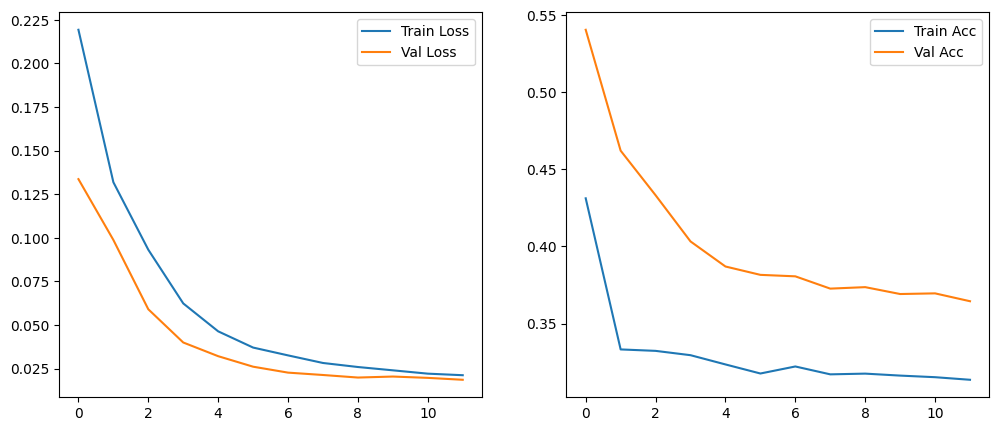

In [28]:
# Przygotowanie danych
label_encoder = LabelEncoder().fit(df['category'])

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['category'], random_state=42)

train_dataset = EnhancedDataset(train_df, processor, label_encoder, is_train=True)
val_dataset = EnhancedDataset(val_df, processor, label_encoder, is_train=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=0)

# Inicjalizacja treningu
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
loss_fn = EnhancedTripletLoss(margin=MARGIN, alpha=ALPHA)

# Funkcje pomocnicze
def calculate_accuracy(text_features, image_features):
    sim = torch.matmul(text_features, image_features.T)
    return (sim.argmax(dim=1) == torch.arange(len(sim)).to(DEVICE)).float().mean().item()

def run_epoch(model, loader, optimizer=None, is_train=True):
    total_loss = 0.0
    total_acc = 0.0
    
    model.train() if is_train else model.eval()
    
    for batch in tqdm(loader, desc=f"{'Train' if is_train else 'Val'} Epoch"):
        anchor_texts = batch['anchor_text']
        anchor_imgs = batch['anchor_img'].to(DEVICE)
        positive_imgs = batch['positive_img'].to(DEVICE)
        negative_imgs = batch['negative_img'].to(DEVICE)
        
        # Przetwarzanie tekstu
        text_inputs = processor(
            text=anchor_texts, 
            return_tensors="pt", 
            padding=True, 
            truncation=True
        ).input_ids.to(DEVICE)
        
        with torch.set_grad_enabled(is_train):
            text_features = model.get_text_features(text_inputs)
            anchor_features = model.get_image_features(anchor_imgs)
            positive_features = model.get_image_features(positive_imgs)
            negative_features = model.get_image_features(negative_imgs)
            
            loss = loss_fn(text_features, anchor_features, positive_features, negative_features)
            
            if is_train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
        total_loss += loss.item()
        total_acc += calculate_accuracy(text_features, anchor_features)
        
    return total_loss/len(loader), total_acc/len(loader)

# Trening
best_val_loss = float('inf')
train_losses, val_losses, train_accs, val_accs = [], [], [], []

def get_alpha_schedule(epoch, total_epochs, start=0.5, end=0.8):
    return start + (end - start) * (epoch / total_epochs)

for epoch in range(EPOCHS):
    # Aktualizuj alpha dla tej epoki
    current_alpha = get_alpha_schedule(epoch, EPOCHS)
    loss_fn.update_alpha(current_alpha)
    
    train_loss, train_acc = run_epoch(model, train_loader, optimizer, is_train=True)
    val_loss, val_acc = run_epoch(model, val_loader, is_train=False)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}\n")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")

# Wizualizacja
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.show()

In [29]:
from transformers import CLIPModel, CLIPProcessor

# Ścieżka do zapisania modelu
save_path = "triplet_clip"

# Zapisz model i processor
model.save_pretrained(save_path)
processor.save_pretrained(save_path)


[]

In [30]:
import torch
import numpy as np
from PIL import Image
from transformers import CLIPModel, CLIPProcessor
from torchvision import transforms
import os

def generate_and_save_embeddings(df, model_path, val_transforms, save_dir="embeddings"):
    """
    Generuje i zapisuje embeddingi dla wszystkich elementów w DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame z kolumnami 'image', 'description', 'category'
        model_path (str): Ścieżka/ID modelu CLIP
        val_transforms (transforms.Compose): Transformacje dla obrazów
        save_dir (str): Katalog do zapisu embeddingów
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Utwórz katalog jeśli nie istnieje
    os.makedirs(save_dir, exist_ok=True)
    
    # Załaduj model i procesor
    model = CLIPModel.from_pretrained(model_path).to(device)
    processor = CLIPProcessor.from_pretrained(model_path)
    
    embeddings_data = {}
    
    for idx, row in df.iterrows():
        # Przetwarzanie tekstu
        text = str(row.get('description', ''))[:500]
        
        # Przetwarzanie obrazu
        image_path = f"data/{row['image']}"
        image = Image.open(image_path).convert("RGB")
        image_tensor = val_transforms(image).unsqueeze(0).to(device)
        
        # Generuj embeddingi
        with torch.no_grad():
            # Tekst
            text_inputs = processor(
                text=[text],
                return_tensors="pt",
                padding="max_length",
                truncation=True,
                max_length=77
            ).to(device)
            text_features = model.get_text_features(**text_inputs)
            
            # Obraz
            image_features = model.get_image_features(pixel_values=image_tensor)
            
        # Łączony embedding
        combined_embedding = (text_features + image_features) / 2
        combined_embedding = combined_embedding / combined_embedding.norm(dim=-1, keepdim=True)
        
        # Zapisz do słownika
        embeddings_data[idx] = {
            "embedding": combined_embedding.cpu().numpy().squeeze(),
            "category": row["category"],
            "image": row["image"]
        }
        
        # Zapisz co 100 elementów
        if idx % 100 == 0:
            np.save(os.path.join(save_dir, f"embeddings_{idx//100}.npy"), embeddings_data)
            embeddings_data = {}
    
    # Zapisz pozostałe elementy
    if embeddings_data:
        np.save(os.path.join(save_dir, f"embeddings_{len(df)//100}.npy"), embeddings_data)

    print(f"Embeddingi zapisane w: {save_dir}")

In [51]:
# Generuj i zapisz embeddingi
generate_and_save_embeddings(df, "triplet_clip", val_transforms, "embeddings_triplet")

Embeddingi zapisane w: embeddings_triplet


In [52]:
from sklearn.metrics.pairwise import cosine_similarity
def calculate_centroid_correlation(embeddings_data, selected_categories):
    """Oblicza macierz korelacji między centroidami kategorii."""
    # Filtruj wybrane kategorie
    filtered = {k: v for k, v in embeddings_data.items() if v["category"] in selected_categories}
    
    # Oblicz centroidy
    categories = list(set(v["category"] for v in filtered.values()))
    centroids = {cat: [] for cat in categories}
    
    for cat in categories:
        cat_embeddings = [v["embedding"] for v in filtered.values() if v["category"] == cat]
        centroids[cat] = np.mean(cat_embeddings, axis=0)
    
    # Oblicz macierz korelacji
    matrix = np.zeros((len(categories), len(categories)))
    for i, cat1 in enumerate(categories):
        for j, cat2 in enumerate(categories):
            similarity = cosine_similarity([centroids[cat1]], [centroids[cat2]])[0][0]
            matrix[i, j] = similarity
    
    return matrix, categories

In [53]:
!pip install seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [43]:
def load_embeddings(save_dir):
    """Ładuje wszystkie zapisane embeddingi z katalogu."""
    all_embeddings = {}
    
    for file in sorted(os.listdir(save_dir)):
        if file.startswith("embeddings_") and file.endswith(".npy"):
            data = np.load(os.path.join(save_dir, file), allow_pickle=True).item()
            all_embeddings.update(data)
    
    return all_embeddings

## I metoda - calculate_centroid_correlation

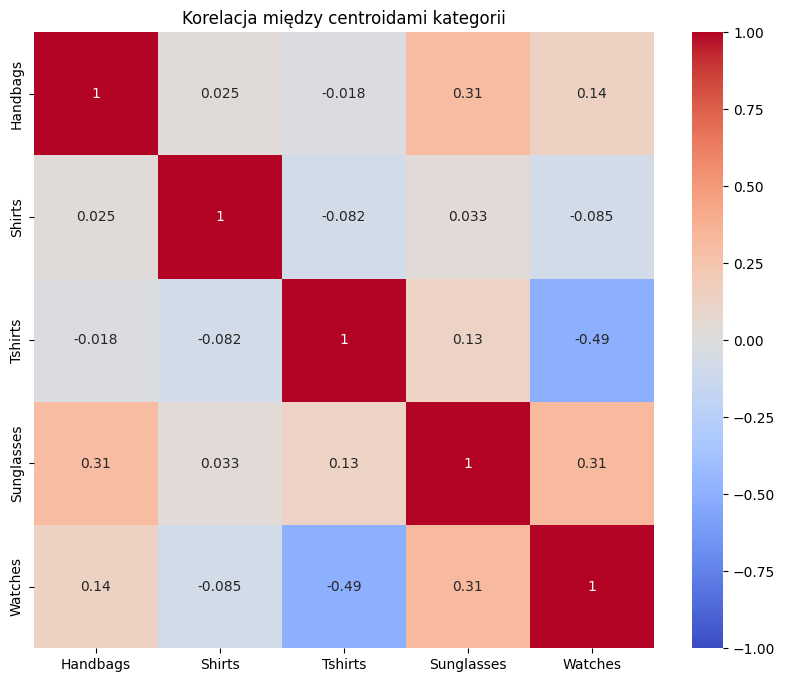

In [54]:
# Załaduj embeddingi
all_embeddings = load_embeddings('embeddings_triplet')

# Oblicz metrykę
selected_categories = ['Sunglasses', 'Handbags', 'Watches', 'Tshirts', 'Shirts']
corr_matrix, categories = calculate_centroid_correlation(all_embeddings, selected_categories)

# Wizualizacja
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    xticklabels=categories,
    yticklabels=categories,
    annot=True,
    cmap="coolwarm",
    vmin=-1,
    vmax=1
)
plt.title("Korelacja między centroidami kategorii")
plt.show()

## II metoda - calculate_tanimoto_similarity

In [56]:


def calculate_tanimoto_similarity(embeddings_data, selected_categories):
    """Oblicza średnie podobieństwo Tanimoto między kategoriami na podstawie zapisanych embeddingów.
    
    Args:
        embeddings_data (dict): Słownik z embeddingami, kluczami są indeksy, wartościami dict z kluczami:
                                'embedding' (np.array), 'category' (str), 'image' (str).
        selected_categories (list): Lista kategorii do analizy (np. ['Sunglasses', 'Handbags']).
    
    Returns:
        tuple: (macierz podobieństw NxN, lista kategorii w kolejności)
    """
    import numpy as np
    from itertools import combinations, product
    from collections import defaultdict

    # Funkcja pomocnicza do obliczania Tanimoto
    def tanimoto(a, b):
        dot = np.dot(a, b)
        norm_a = np.dot(a, a)
        norm_b = np.dot(b, b)
        return dot / (norm_a + norm_b - dot) if (norm_a + norm_b - dot) != 0 else 0.0

    # Grupowanie embeddingów według kategorii
    category_embeddings = defaultdict(list)
    for item in embeddings_data.values():
        if item['category'] in selected_categories:
            category_embeddings[item['category']].append(item['embedding'])

    # Inicjalizacja macierzy wynikowej
    n = len(selected_categories)
    similarity_matrix = np.zeros((n, n))

    # Iteracja po wszystkich parach kategorii
    for i, cat1 in enumerate(selected_categories):
        for j, cat2 in enumerate(selected_categories):
            embs1 = category_embeddings.get(cat1, [])
            embs2 = category_embeddings.get(cat2, [])

            if not embs1 or not embs2:
                similarity_matrix[i, j] = 0.0
                continue

            # Obliczanie wszystkich par
            total_similarity = 0.0
            count = 0

            if cat1 == cat2:
                # Kombinacje bez powtórzeń (pomiń pary tego samego elementu)
                for a, b in combinations(embs1, 2):
                    total_similarity += tanimoto(a, b)
                    count += 1
            else:
                # Wszystkie możliwe pary między kategoriami
                for a, b in product(embs1, embs2):
                    total_similarity += tanimoto(a, b)
                    count += 1

            similarity_matrix[i, j] = total_similarity / count if count > 0 else 0.0

    return similarity_matrix, selected_categories
	

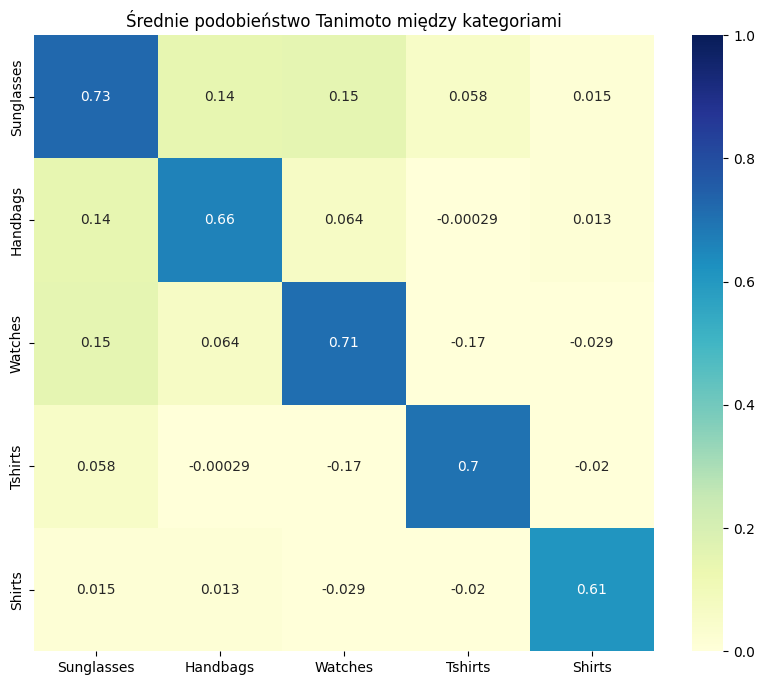

In [57]:
# Załaduj zapisane embeddingi
# all_embeddings = load_embeddings()

# Wybrane kategorie
selected_categories = ['Sunglasses', 'Handbags', 'Watches', 'Tshirts', 'Shirts']

# Oblicz macierz Tanimoto
tanimoto_matrix, categories = calculate_tanimoto_similarity(all_embeddings, selected_categories)

# Wizualizacja
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(
    tanimoto_matrix,
    xticklabels=categories,
    yticklabels=categories,
    annot=True,
    cmap="YlGnBu",
    vmin=0,
    vmax=1
)
plt.title("Średnie podobieństwo Tanimoto między kategoriami")
plt.show()	

## III metoda calculate_category_similarity_matrix

In [60]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def calculate_category_similarity_matrix(embeddings_data, selected_categories):
    """Oblicza macierz średnich podobieństw między wszystkimi parami kategorii.
    
    Args:
        embeddings_data (dict): Słownik z embeddingami w formacie {index: {'embedding': ..., 'category': ...}}
        selected_categories (list): Lista kategorii do uwzględnienia (np. ['Sunglasses', 'Handbags'])
    
    Returns:
        tuple: (macierz NxN średnich podobieństw, lista kategorii w kolejności)
    """
    # Grupujemy embeddingi według kategorii
    category_dict = {cat: [] for cat in selected_categories}
    for item in embeddings_data.values():
        if item['category'] in selected_categories:
            category_dict[item['category']].append(item['embedding'])
    
    # Inicjalizacja macierzy
    n = len(selected_categories)
    similarity_matrix = np.zeros((n, n))
    
    # Iteracja po wszystkich parach kategorii
    for i, cat1 in enumerate(selected_categories):
        embeddings1 = category_dict.get(cat1, [])
        if not embeddings1:
            continue
            
        for j, cat2 in enumerate(selected_categories):
            embeddings2 = category_dict.get(cat2, [])
            if not embeddings2:
                continue
                
            # Obliczamy wszystkie kombinacje między kategoriami
            sims = cosine_similarity(embeddings1, embeddings2)
            
            # Dla tej samej kategorii: bierzemy tylko górny trójkąt bez diagonali
            if cat1 == cat2:
                # POPRAWIONA LINIA
                sims = sims[np.triu_indices(len(embeddings1), k=1)]
                
            similarity_matrix[i, j] = np.mean(sims) if sims.size > 0 else 0.0
    
    return similarity_matrix, selected_categories

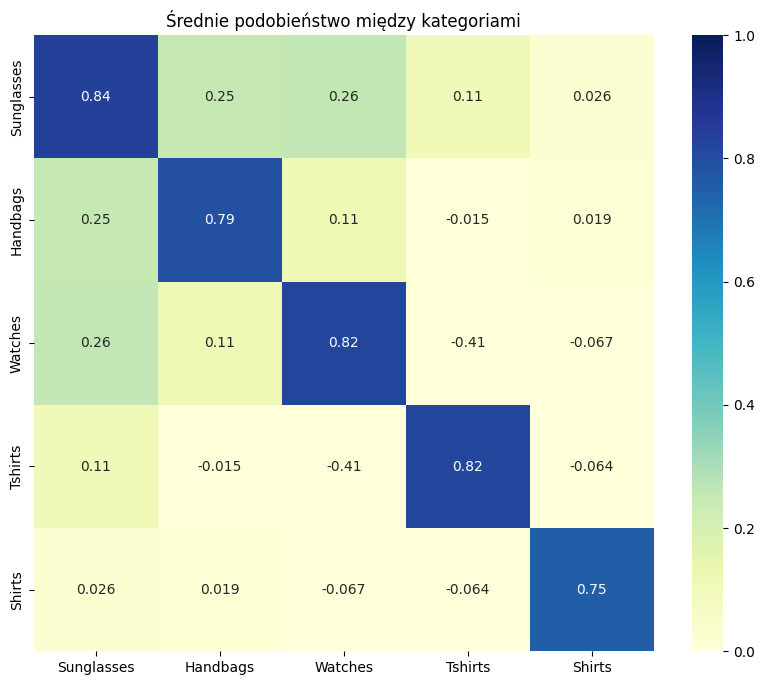

In [61]:
# Krok 1: Wczytaj zapisane embeddingi
# all_embeddings = load_embeddings()

# Krok 2: Wybierz interesujące kategorie
# selected_cats = ['Sunglasses', 'Handbags', 'Watches']

# Krok 3: Oblicz macierz
matrix, categories = calculate_category_similarity_matrix(all_embeddings, selected_categories)

# Krok 4: Wizualizacja
plt.figure(figsize=(10, 8))
sns.heatmap(
    matrix,
    xticklabels=categories,
    yticklabels=categories,
    annot=True,
    cmap="YlGnBu",
    vmin=0,
    vmax=1
)
plt.title("Średnie podobieństwo między kategoriami")
plt.show()

In [72]:
matrix

array([[ 0.83550006,  0.25038537,  0.26103869,  0.10509961,  0.02617572],
       [ 0.25038528,  0.78913838,  0.11335496, -0.01478246,  0.01939092],
       [ 0.26103881,  0.11335491,  0.82394391, -0.40619549, -0.06658943],
       [ 0.10509963, -0.01478245, -0.40619603,  0.81717259, -0.06430565],
       [ 0.02617572,  0.01939092, -0.06658948, -0.06430575,  0.74643326]])

## IV metoda calculate_similarity_metrics

In [62]:
def calculate_similarity_metrics(embeddings_data, selected_categories):
    """Oblicza statystyki podobieństw wewnątrz i między kategoriami na podstawie zapisanych embeddingów.
    
    Args:
        embeddings_data (dict): Słownik z embeddingami (klucze: indeksy, wartości: dict z 'embedding', 'category').
        selected_categories (list): Lista kategorii do analizy (np. ['Sunglasses', 'Handbags']).
    
    Returns:
        dict: Słownik z kluczami 'intra_mean', 'intra_std', 'inter_mean', 'inter_std', 'gap'.
    """
    import numpy as np
    from sklearn.metrics.pairwise import cosine_similarity

    # Filtruj embeddingi tylko z wybranych kategorii
    filtered_embeddings = []
    filtered_labels = []
    
    for item in embeddings_data.values():
        if item['category'] in selected_categories:
            filtered_embeddings.append(item['embedding'])
            filtered_labels.append(item['category'])
    
    if not filtered_embeddings:
        return {
            "intra_mean": 0,
            "intra_std": 0,
            "inter_mean": 0,
            "inter_std": 0,
            "gap": 0
        }
    
    # Oblicz wszystkie pary
    intra_similarities = []
    inter_similarities = []
    
    n = len(filtered_embeddings)
    for i in range(n):
        for j in range(i + 1, n):
            sim = cosine_similarity(
                [filtered_embeddings[i]], 
                [filtered_embeddings[j]]
            )[0][0]
            
            if filtered_labels[i] == filtered_labels[j]:
                intra_similarities.append(sim)
            else:
                inter_similarities.append(sim)
    
    # Oblicz statystyki
    intra_mean = np.mean(intra_similarities) if intra_similarities else 0
    intra_std = np.std(intra_similarities) if intra_similarities else 0
    inter_mean = np.mean(inter_similarities) if inter_similarities else 0
    inter_std = np.std(inter_similarities) if inter_similarities else 0
    
    return {
        "intra_mean": intra_mean,
        "intra_std": intra_std,
        "inter_mean": inter_mean,
        "inter_std": inter_std,
        "gap": intra_mean - inter_mean
    }

In [63]:
# Załaduj zapisane embeddingi
# all_embeddings = load_embeddings()

# Wybrane kategorie
# selected_categories = ['Sunglasses', 'Handbags', 'Watches', 'Tshirts', 'Shirts']

# Oblicz metryki
metrics = calculate_similarity_metrics(all_embeddings, selected_categories)

# Wydrukuj wyniki
print(f"""
Podobieństwa wewnątrz kategorii:
- Średnia: {metrics['intra_mean']:.3f} ± {metrics['intra_std']:.3f}

Podobieństwa między kategoriami:
- Średnia: {metrics['inter_mean']:.3f} ± {metrics['inter_std']:.3f}

Różnica (gap): {metrics['gap']:.3f}
""")

KeyboardInterrupt: 

## V metoda - obliczenia statystyk

In [58]:
def calculate_metrics_from_embeddings(embeddings_data):
    """
    Oblicza metryki na podstawie wczytanych embeddingów
    """
    embeddings = embeddings_data['embeddings']
    categories = embeddings_data['categories']
    
    # Kodowanie kategorii
    unique_categories = np.unique(categories)
    category_to_idx = {cat: i for i, cat in enumerate(unique_categories)}
    encoded_categories = np.array([category_to_idx[cat] for cat in categories])
    
    # Obliczanie macierzy podobieństw
    similarity_matrix = torch.mm(embeddings, embeddings.T)
    
    # Tworzenie masek
    category_tensor = torch.tensor(encoded_categories)
    same_mask = category_tensor.unsqueeze(1) == category_tensor.unsqueeze(0)
    diag_mask = ~torch.eye(len(categories), dtype=torch.bool)
    
    # Obliczanie średnich
    intra_sim = similarity_matrix[same_mask & diag_mask]
    inter_sim = similarity_matrix[~same_mask & diag_mask]
    
    return {
        'intra_mean': intra_sim.mean().item(),
        'intra_std': intra_sim.std().item(),
        'inter_mean': inter_sim.mean().item(),
        'inter_std': inter_sim.std().item(),
        'gap': intra_sim.mean().item() - inter_sim.mean().item()
    }

In [59]:
metrics = calculate_metrics_from_embeddings(all_embeddings)

print(f"""
Podobieństwo wewnątrz kategorii: {metrics['intra_mean']:.3f} ± {metrics['intra_std']:.3f}
Podobieństwo między kategoriami: {metrics['inter_mean']:.3f} ± {metrics['inter_std']:.3f}
Różnica (gap): {metrics['gap']:.3f}
""")

KeyError: 'embeddings'

In [69]:
import torch
from PIL import Image
import numpy as np
from transformers import CLIPModel, CLIPProcessor
from sklearn.preprocessing import LabelEncoder

def calculate_metrics2_optimized(df, model_path, batch_size=32):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Ładowanie modelu i procesora
    model = CLIPModel.from_pretrained(model_path).to(device)
    processor = CLIPProcessor.from_pretrained(model_path)
    
    # Przygotowanie danych
    texts = []
    image_paths = []
    categories_list = []
    
    for _, row in df.iterrows():
        text = (
            str(row.get('description', ''))[:500] 
            if isinstance(row.get('description', ''), str) 
            else ''
        )
        texts.append(text)
        image_paths.append(f"data/{row['image']}")
        categories_list.append(row['category'])
    
    # Kodowanie kategorii
    le = LabelEncoder()
    categories_encoded = le.fit_transform(categories_list)
    categories_tensor = torch.tensor(categories_encoded).to(device)
    
    # Przetwarzanie w partiach
    embeddings = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        batch_image_paths = image_paths[i:i+batch_size]
        
        # Ładowanie obrazów
        batch_images = []
        for path in batch_image_paths:
            batch_images.append(Image.open(path).convert("RGB"))
        
        # Przetwarzanie tekstu i obrazów
        inputs = processor(
            text=batch_texts,
            images=batch_images,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=77,
        ).to(device)
        
        # Obliczanie embeddingów
        with torch.no_grad():
            text_features = model.get_text_features(input_ids=inputs['input_ids'])
            image_features = model.get_image_features(pixel_values=inputs['pixel_values'])
        
        # Średnia i normalizacja
        batch_embeddings = (text_features + image_features) / 2
        batch_embeddings = batch_embeddings / batch_embeddings.norm(dim=-1, keepdim=True)
        embeddings.append(batch_embeddings)
    
    embeddings = torch.cat(embeddings, dim=0)
    
    # Macierz podobieństw
    similarity_matrix = torch.mm(embeddings, embeddings.T)
    
    # Maski kategorii
    n = len(embeddings)
    same_category = (categories_tensor.unsqueeze(1) == categories_tensor.unsqueeze(0))
    non_diagonal = ~torch.eye(n, dtype=torch.bool, device=device)
    
    # Obliczanie średnich
    same_similarities = similarity_matrix[same_category & non_diagonal]
    diff_similarities = similarity_matrix[~same_category & non_diagonal]
    
    avg_same = same_similarities.mean().item() if len(same_similarities) > 0 else 0
    avg_diff = diff_similarities.mean().item() if len(diff_similarities) > 0 else 0
    
    return avg_same, avg_diff

In [70]:
triplet_results = calculate_metrics2_optimized(df, "triplet_clip")

In [71]:
triplet_results

(0.80498868227005, -0.07543526589870453)